In [659]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
import re
import contractions
import string
nltk.download('stopwords')
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from statistics import mean
import math
from lazypredict.Supervised import LazyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import glob
from IPython.core.display import HTML

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [660]:
deceptive_files = glob.glob('./Deceptive/*.txt')
dfs = []

for file in deceptive_files:
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
        dfs.append([text, 0])

deceptive_df = pd.DataFrame(dfs, columns=['Statement', 'Is_Truth'])

In [661]:
truthful_files = glob.glob('./Truthful/*.txt')
dfs = []

for file in truthful_files:
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
        dfs.append([text, 1])

truthful_df = pd.DataFrame(dfs, columns=['Statement', 'Is_Truth'])

In [662]:
combined_df = pd.concat([deceptive_df, truthful_df])

In [663]:
deceptive_df.shape

(61, 2)

In [664]:
truthful_df.shape

(60, 2)

In [665]:
combined_df.shape

(121, 2)

In [697]:
def preprocess_text(input_df):
    input_df["tokens"] = input_df["Statement"].apply(lambda x: nltk.tokenize.sent_tokenize(x))
    input_df["tokens"] = input_df["tokens"].apply(lambda x: [y.lower() for y in x])
    input_df["tokens"] = input_df["tokens"].apply(lambda x: [re.sub('[0-9]', '', y) for y in x])
    input_df["tokens"] = input_df["tokens"].apply(lambda x: [contractions.fix(y) for y in x])
    input_df["tokens"] = input_df["tokens"].apply(lambda x: [y.translate(str.maketrans('', '', string.punctuation)) for y in x])
    input_df["tokens"] = input_df["tokens"].apply(lambda x: [nltk.tokenize.word_tokenize(y) for y in x])
    input_df["tokens"] = input_df["tokens"].apply(lambda x: [list(filter(lambda y: y not in set(nltk.corpus.stopwords.words('english')), y)) for y in x])
    input_df["tokens"] = input_df["tokens"].apply(lambda x: [y for y in x if y != []])
    return input_df

In [698]:
combined_df = preprocess_text(combined_df)

In [699]:
# X_train, X_test, y_train, y_test = train_test_split(combined_df['Statement'], combined_df['Is_Truth'], test_size=0.3, random_state = 42)

# TFIDF

In [700]:
new_combined_df = pd.DataFrame(columns=combined_df.columns)

for index, row in combined_df.iterrows():
    for s in row['tokens']:
        if len(s) > 1:
            d = {'Statement': row['Statement'], 'Is_Truth': row['Is_Truth'], 'tokens': (np.array(' '.join(s))).tolist()}
            new_combined_df = pd.concat([new_combined_df, pd.DataFrame(data=d, index=[0])])

In [701]:
X_train, X_test, y_train, y_test = train_test_split(new_combined_df['tokens'], new_combined_df['Is_Truth'], stratify=new_combined_df['Is_Truth'], test_size=0.2, random_state = 42)

In [702]:
vectorizer = TfidfVectorizer()

In [703]:
# train_sent_df = []
# test_sent_df = []

# train_y = []
# test_y = []

# y_train = y_train.to_list()
# y_test = y_test.to_list()

# for idx, row in enumerate(X_train):
#     for s in row:
#         train_sent_df.append((np.array(' '.join(s))).tolist())
#         train_y.append(y_train[idx])
        
# for idx, row in enumerate(X_test):
#     for s in row:
#         test_sent_df.append((np.array(' '.join(s))).tolist())
#         test_y.append(y_test[idx])

In [704]:
# x_train_tfidf = vectorizer.fit_transform(train_sent_df)
# y_train_tfidf = train_y

# x_test_tfidf = vectorizer.transform(test_sent_df)
# y_test_tfidf = test_y

x_train_tfidf = vectorizer.fit_transform(X_train.to_list())
y_train_tfidf = y_train.astype('int')

x_test_tfidf = vectorizer.transform(X_test.to_list())
y_test_tfidf = y_test.astype('int')

## SVM

In [881]:
svc = SVC(probability=True, kernel="sigmoid", C=2)
#svc = SVC(probability=True, kernel="linear")
svc.fit(pd.DataFrame(x_train_tfidf.toarray()), pd.DataFrame(y_train_tfidf))

SVC(C=2, kernel='sigmoid', probability=True)

In [882]:
pred = svc.predict(pd.DataFrame(x_test_tfidf.toarray()))
pred_proba = svc.predict_proba(pd.DataFrame(x_test_tfidf.toarray()))

In [883]:
print(classification_report(pred, y_test_tfidf))

              precision    recall  f1-score   support

           0       0.79      0.71      0.75        42
           1       0.72      0.79      0.76        39

    accuracy                           0.75        81
   macro avg       0.76      0.75      0.75        81
weighted avg       0.76      0.75      0.75        81



Text(0.5, 1.0, 'Confusion Matrix')

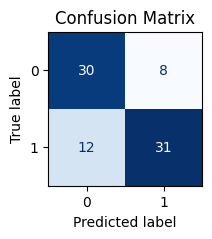

In [884]:
disp = ConfusionMatrixDisplay(confusion_matrix(np.array(y_test_tfidf).ravel(), pred))

fig, ax = plt.subplots(figsize=(2,2))
disp.plot(
    include_values=True,
    cmap='Blues',
    colorbar=False,
    ax=ax
)
disp.ax_.set_title(f"Confusion Matrix")

In [885]:
X_train.shape

(323,)

In [710]:
X_test.shape

(81,)

In [711]:
len(new_combined_df[(new_combined_df["Is_Truth"]==1)])

216

In [712]:
new_combined_df.shape

(404, 3)

In [717]:
x_train_tfidf.toarray()

(323, 1142)

In [720]:
x_test_tfidf.shape

(81, 1142)

In [887]:
import joblib
joblib.dump(svc, 'text_SVC.pkl')

['text_SVC.pkl']